In [2]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
import MetaTrader5 as mt5
from account_credentials import LOGIN,PASSWORD,SERVER
from datetime import datetime

is_initialized = mt5.initialize()
print('initialize: ', is_initialized)

is_logged_in = mt5.login(LOGIN, PASSWORD, SERVER)
print('logged in: ', is_logged_in)
print('\n')
account_info = mt5.account_info()
print(datetime.now(),
    '| Login: ', account_info.login,
    '| Balance: ', account_info.balance,
    '| Equity: ' , account_info.equity)

initialize:  True
logged in:  True


2023-04-17 13:57:47.818418 | Login:  114226077 | Balance:  500.0 | Equity:  500.0


In [4]:
symbol = 'XAUUSD'
number_of_date= 50000
timeframe = mt5.TIMEFRAME_M5
from_date = datetime.now()

df = pd.DataFrame(mt5.copy_rates_from(symbol,timeframe,from_date,number_of_date))
df["time"] = pd.to_datetime(df["time"], unit="s")
df = df.rename(columns={'time': 'date','tick_volume':'volume'})
df = df.set_index("date")
df

,open,high,low,close,volume,spread,real_volume
date,,,,,,,
2022-08-01 05:35:00,1760.462,1760.879,1760.442,1760.845,170,125,0
2022-08-01 05:40:00,1760.833,1761.005,1760.308,1760.493,225,125,0
2022-08-01 05:45:00,1760.492,1760.527,1759.614,1760.030,270,125,0
2022-08-01 05:50:00,1760.045,1760.145,1758.333,1758.885,389,125,0
2022-08-01 05:55:00,1758.869,1759.132,1758.575,1759.064,264,125,0
...,...,...,...,...,...,...,...
2023-04-17 06:35:00,2011.347,2012.087,2010.943,2011.265,362,125,0
2023-04-17 06:40:00,2011.240,2012.271,2011.123,2012.246,332,125,0
2023-04-17 06:45:00,2012.249,2012.908,2011.102,2011.473,415,125,0


In [5]:
#### Adding shift windows
# targets, check the highest gold price attained in the next 4 hours
highs = df['high'].rolling(window=4).max().shift(-4)
lows = df['low'].rolling(window=4).min().shift(-4)

# create new columns for conditions
df['high_close_diff'] = highs - df['close'].shift(1)
df['low_close_diff'] = lows - df['close'].shift(1)

df = df.dropna()

In [6]:
df.shape

(49995, 9)

In [7]:
def reco(row):
    if row.high_close_diff >= 3.3: 
        return 0
    elif row.low_close_diff <= -4.3:#I use 3 plus .3 for bit offer off-set, and 1 in case of delay ordering cause price to change.
        return 1
    else:
        return 0

df['target'] = df.apply(reco,axis=1)


print('1', (df['target'] == 1).sum())
print('0', (df['target'] == 0).sum())

df_simu = df
df = df[['open','high','low','close','target']]

1 2412
0 47583


C:\Users\pkong\AppData\Local\Temp\ipykernel_17216\1888599090.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df.apply(reco,axis=1)


In [8]:
df.shape

(49995, 5)

In [11]:
n = len(df)
print(n)


train_n = int(round(n*0.70))
print('number of training set: ', train_n)

cross_n = int(round(n*0.05,0))
print('number of cross validation set: ', cross_n)

test_n = int(round(n*0.25,0))
print('number of test set: ', test_n)

print('sum', train_n + cross_n + test_n)


train_start = str(df.iloc[0].name)
train_end = str(df.iloc[train_n].name)
print('Training set start: {0} \n Training set end: {1}'.format(train_start,train_end))
#print(df.loc[train_start:train_end])

cross_start = str(df.iloc[train_n+1].name)
cross_end = str(df.iloc[train_n+cross_n].name)
print('cross validation set start: {0} \n cross validation set end: {1}'.format(cross_start,cross_end))
#print(df.loc[cross_start:cross_end])

# test_start = str(df.iloc[train_n + cross_n +1].name)
test_start = str(df.iloc[n - test_n+1].name)
test_end = str(df.iloc[n-1].name)
print('test set start: {0} \n test set end: {1}'.format(test_start,test_end))
#print(df.loc[test_start:])

X = df.drop(['target'], axis=1)

y = df['target']


X_train = np.asarray(X.loc[train_start:train_end])
y_train = np.asarray(y.loc[train_start:train_end])

X_cross = np.asarray(X.loc[cross_start:cross_end])
y_cross = np.asarray(y.loc[cross_start:cross_end])

X_test = np.asarray(X.loc[test_start:])
y_test =np.asarray(y.loc[test_start:])



#Extra for GridSearch
X_train_cv = np.asarray(X.loc[train_start:cross_end])
y_train_cv = np.asarray(y.loc[train_start:cross_end])


X_train.shape, y_train.shape, X_cross.shape, y_cross.shape, X_test.shape, y_test.shape, X_train_cv.shape, y_train_cv.shape


# Below is for later simulation
df_simu_test = df_simu.loc[test_start:]

49995
number of training set:  34996
number of cross validation set:  2500
number of test set:  12499
sum 49995
Training set start: 2022-08-01 05:40:00 
 Training set end: 2023-01-27 16:00:00
cross validation set start: 2023-01-27 16:05:00 
 cross validation set end: 2023-02-09 17:30:00
test set start: 2023-02-09 17:35:00 
 test set end: 2023-04-17 06:35:00


In [12]:
#Create Normalized Data
def normalize_data(X):
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    X_norm = (X - means) / stds
    return X_norm, means, stds

#This can run multiple times
X_train_n, X_train_means, X_train_stds = normalize_data(X_train)

def normalize_data_new(X,means,stds):
    X_norm = (X - means) / stds
    return X_norm

X_cross_n = normalize_data_new(X_cross,X_train_means,X_train_stds)
X_test_n = normalize_data_new(X_test,X_train_means,X_train_stds)

##### Export Scaler

In [13]:
from joblib import dump
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sum(X_test_n != X_test_scaled)

dump(scaler, 'scaler_short_c.pkl')

['scaler_short_c.pkl']

##### Test import scaler

In [14]:
from joblib import load
scaler2 = load('scaler_short_c.pkl')
X_test_scaled2 = scaler2.transform(X_test)
sum((X_test_n == X_test_scaled2) & (X_test_scaled == X_test_scaled2))

array([12498, 12498, 12498, 12498])

##### Final verification

In [15]:
mean = scaler.mean_
std = scaler.scale_
mean2 = scaler2.mean_
std2 = scaler2.scale_
print('mean scaler one',mean)
print('mean scaler two',mean2)
print('mean manual nor',X_train_means)

print('std scaler one',std)
print('std scaler two',std2)
print('std manual nor',X_train_stds)


mean scaler one [1752.03332246 1752.64062957 1751.43216116 1752.03957448]
mean scaler two [1752.03332246 1752.64062957 1751.43216116 1752.03957448]
mean manual nor [1752.03332246 1752.64062957 1751.43216116 1752.03957448]
std scaler one [80.6121871  80.59449647 80.63236456 80.61774939]
std scaler two [80.6121871  80.59449647 80.63236456 80.61774939]
std manual nor [80.6121871  80.59449647 80.63236456 80.61774939]


C=0.01, Train score=0.9586250250021431, cross score=0.9248
C=0.1, Train score=0.9587393205131869, cross score=0.9252
C=0.5, Train score=0.9593965197016887, cross score=0.9272
C=1, Train score=0.9599679972569077, cross score=0.9296
C=1.5, Train score=0.9603108837900391, cross score=0.9292
C=2, Train score=0.960425179301083, cross score=0.9296
C=10, Train score=0.960996656856302, cross score=0.9316
The best 'C' is: 10
score: 0.93
Accuracy_score:  0.93
weight avg 0.91
jaccard:  0.1
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2312
           1       0.90      0.10      0.18       188

    accuracy                           0.93      2500
   macro avg       0.92      0.55      0.57      2500
weighted avg       0.93      0.93      0.91      2500



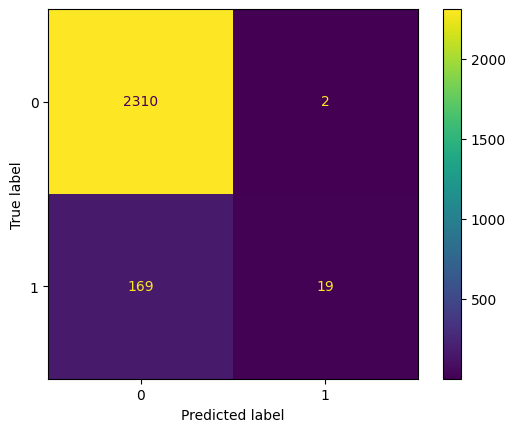

In [16]:
# Define a list of hyperparameters to loop through
#################larger value of C imposes less regularization on the model
Cs = [0.01, 0.1,0.5, 1, 1.5, 2, 10]

# Initialize variables to keep track of the best hyperparameters and their corresponding score
best_score = 0
best_C = None
max_iter = 20000
features_X_train = X_train_n
target_y_train = y_train
features_X_cross = X_cross_n
target_y_cross = y_cross
# Loop through the hyperparameters
for C in Cs:
    lsvm = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, C=C, max_iter=max_iter)
    lsvm.fit(X_train_n, y_train)
    train_score = lsvm.score(features_X_train, target_y_train)
    cross_score = lsvm.score(features_X_cross, target_y_cross)
    print(f"C={C}, Train score={train_score}, cross score={cross_score}")
    
    # Update the best hyperparameters and their corresponding score if applicable
    if train_score > best_score:
        best_score = train_score
        best_C = C

print("The best 'C' is:", best_C)
# Create the LinearSVC model with normalization and the best value of C
lsvm = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, C=best_C, max_iter=max_iter)

# Fit the model to the training data
lsvm.fit(features_X_train, target_y_train)


#EVALUATION
test_score = round(lsvm.score(features_X_cross, target_y_cross),2)
print("score:", test_score)


yhat_m1 = lsvm.predict(features_X_cross)
accuracy_m1 = round(accuracy_score(target_y_cross,yhat_m1),2)
print('Accuracy_score: ', accuracy_m1)

f1 = round(f1_score(target_y_cross, yhat_m1, average='weighted'), 2)
print('weight avg', f1)

jaccard = round(jaccard_score(target_y_cross, yhat_m1,pos_label=1),2)
print('jaccard: ', jaccard)

print(metrics.classification_report(target_y_cross, yhat_m1))


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_estimator(lsvm, features_X_cross, target_y_cross)


In [17]:
X_test_simu = X.loc[test_start:]
X_test_simu_n = normalize_data_new(X_test_simu,X_train_means,X_train_stds)

X_cross_simu = X.loc[cross_start:cross_end]
X_cross_simu_n = normalize_data_new(X_cross_simu,X_train_means,X_train_stds)

def predict_count(data_simu):
    adding = []
    for i in range(0,len(data_simu)):
        prediction = str(lsvm.predict(data_simu.iloc[i].values.reshape(1,-1))).strip('[]')
        adding.append(prediction)
    print(adding.count('0'))
    print(adding.count('1'))


print('-----cross-----')
print('The value should be:>> yhat = 0: {0}<<, >> yhat = 1: {1}<<'.format(np.count_nonzero(yhat_m1 == 0),np.count_nonzero(yhat_m1 == 1)))
predict_count(X_cross_simu_n)

print('-----test-----')
predict_count(X_test_simu_n)

-----cross-----
The value should be:>> yhat = 0: 2479<<, >> yhat = 1: 21<<
2479
21
-----test-----
12377
121


In [ ]:
X_test_simu_n.shape

In [18]:
def predict_simu(model, data_simu_x_n, data_simu_y, initial_capital):
    capital = initial_capital
    win_count = 0
    lost_count = 0
    no_order_count = 0
    record_result = []
    record_capital = []
    record_date = []
    consecutive_lost = 0
    consecutive_lost_max = 0
    for i in range(0, len(data_simu_x_n)):
        prediction = model.predict(data_simu_x_n.iloc[i].values.reshape(1,-1))
        
        if prediction == 1 and data_simu_y[i] == 1:
            outcome = 3
            capital += outcome
            win_count += 1
            order_record = 'win-------- prediction = {0}, actual = {1}'.format(prediction,data_simu_y[i])
            result = 'win'
        elif prediction == 1 and data_simu_y[i] == 0:
            outcome = -3.3
            capital += outcome
            lost_count += 1
            order_record = 'lost------- prediction = {0}, actual = {1}'.format(prediction,data_simu_y[i])
            result = 'lost'
        elif prediction == 0:
            no_order_count +=1
            order_record = 'no order--- prediction = {0}, actual = {1}'.format(prediction, data_simu_y[i])
            capital = capital
            result = 'no order'
        else:
            raise ValueError('no condition met')
        record_date.append(data_simu_x_n.iloc[i].name)
        record_result.append(order_record)
        record_capital.append(capital)

        #Calculate Consecutive Lost
        if result == 'lost':
            consecutive_lost += -3.3
            if consecutive_lost <= consecutive_lost_max:
                consecutive_lost_max = consecutive_lost
        if result == 'win':
            if consecutive_lost <= consecutive_lost_max:
                consecutive_lost_max = consecutive_lost
            consecutive_lost = 0

    total_return = ((capital - initial_capital) / initial_capital)*100
    sim_df = pd.DataFrame({'record_date':record_date,
                           'record_result':record_result,
                           'record_capital': record_capital})
    sim_df.set_index('record_date', inplace=True)

    return win_count, lost_count, no_order_count, capital, total_return, sim_df, consecutive_lost_max


In [19]:
win_count, lost_count, no_order_count, capital, total_return, sim_df, consecutive_lost_max = predict_simu(lsvm, X_test_simu_n, y_test, 500)                                                          
print('Total Return: {0}%'.format(round(total_return,0)))
print('Final Capital: ${0}'.format(round(capital,0)))
print('Win Count: ',win_count)
print('Lost Count: ',lost_count)
print('No Order Count: ', no_order_count)
print('Max Consecutive Lost: {0} trades'.format(consecutive_lost_max/-3.3))
day_one = X_test_simu_n.iloc[0].name.to_pydatetime().date()
day_final = X_test_simu_n.iloc[len(X_test_simu_n)-1].name.to_pydatetime().date()
print('Total day on trading: {0} days'.format((day_final - day_one).days))
accuracy = win_count / ( win_count+ lost_count)
print(f"Accuracy {accuracy:.2f}%")

Total Return: 41.0%
Final Capital: $706.0
Win Count:  96
Lost Count:  25
No Order Count:  12377
Max Consecutive Lost: 2.0 trades
Total day on trading: 67 days
Accuracy 0.79%


# Export the simulation data set:

In [20]:
np.savetxt('y_short_simu_c.csv', y_test, delimiter=',')
X_test_simu_n.to_csv('X_short_simu_c.csv')

##### To import the file use:

```python
y_test = np.loadtxt('y_short_sim_c.csv', delimiter=',')
X_test_simu_n = pd.read_csv('X_short_simu_c.csv',index_col='datetime', parse_dates=True)
```

<Axes: xlabel='record_date'>

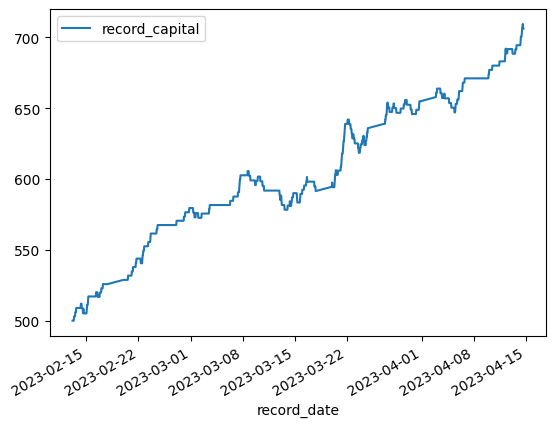

In [19]:
sim_df.plot(y='record_capital')

# Saving model using Pickle

In [21]:
import pickle
print('version should be 4.0:',pickle.format_version)
pickle.dump(lsvm,open('lsvm_xauusd_short_c.pkl','wb'))

version should be 4.0: 4.0


In [22]:
pickled_model=pickle.load(open('lsvm_xauusd_short_c.pkl','rb'))

In [23]:
model_input = [-2.839808,-2.806494,-2.828501,-2.791640]
model_input = np.array(model_input).reshape(1,-1)
model_input
pickled_model.predict(model_input)

array([0], dtype=int64)